## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Нужно разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

- Построим модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- Рассмотрим дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, выделим сегменты покупателей и разработаем для них персонализированные предложения.

## Описание данных

**market**  
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.  

**market_money**   
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

**market_time**  
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
минут — значение времени, проведённого на сайте, в минутах.

**money**  
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

## Загрузка данных

In [1]:
!pip install -U scikit-learn -q

In [2]:
!pip install yellowbrick -q

In [3]:
!pip install shap -q

In [4]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
import sklearn
print(sklearn.__version__)

1.4.0


In [6]:
# библиотеки
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)

from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
    fbeta_score,
    roc_curve,
    RocCurveDisplay,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from yellowbrick.classifier.rocauc import roc_auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification

In [7]:
# данные
market = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal = ',')

### market

In [8]:
market.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [9]:
market = market.rename(columns={
    'Покупательская активность' : 'Покупательская_активность',
    'Тип сервиса' : 'Тип_сервиса',
    'Разрешить сообщать' : 'Разрешить_сообщать'})

In [10]:
# приводим названия столбцов к нижнему регистру
market.columns = market.columns.str.lower()

In [11]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

### market_money

In [12]:
market_money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [13]:
# приводим названия столбцов к нижнему регистру
market_money.columns = market_money.columns.str.lower()

In [14]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


### market_time

In [15]:
market_time.head(5)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [16]:
# приводим названия столбцов к нижнему регистру
market_time.columns = market_time.columns.str.lower()

In [17]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


### money


In [18]:
money.head(5)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [19]:
# приводим названия столбцов к нижнему регистру
money.columns = money.columns.str.lower()

In [20]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


##  Предобработка данных

### market

In [21]:
market.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [22]:
market.duplicated().sum()

0

In [23]:
# создадим функцию для проверки неявных дубликатов
def uniq(data):
    x = data.select_dtypes(include='object').columns.tolist()
    for i in x:
        print(i)
        print(data[i].unique())
        print(data[i].nunique())
        print()

In [24]:
uniq(market)

покупательская_активность
['Снизилась' 'Прежний уровень']
2

тип_сервиса
['премиум' 'стандартт' 'стандарт']
3

разрешить_сообщать
['да' 'нет']
2

популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
6



In [25]:
# заметили неявный дубликат "стандартт" -> "стандарт"
market['тип_сервиса'] = market['тип_сервиса'].replace('стандартт', 'стандарт')

In [26]:
# посмотрим на форму датасета
market.shape

(1300, 13)

### market_money

In [27]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [28]:
market_money.duplicated().sum()

0

In [29]:
uniq(market_money)

период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
3



In [30]:
# посмотрим на форму датасета
market_money.shape

(3900, 3)

### market_time

In [31]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [32]:
market_time.duplicated().sum()

0

In [33]:
uniq(market_time)

период
['текущий_месяц' 'предыдцщий_месяц']
2



In [34]:
# заметили неявный дубликат "предыдцщий_месяц" -> "предыдущий_месяц"
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [35]:
market_time.shape

(2600, 3)

### money

In [36]:
money.head(5)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [37]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

In [38]:
money.duplicated().sum()

0

In [39]:
money.shape

(1300, 2)

## Исследовательский анализ данных

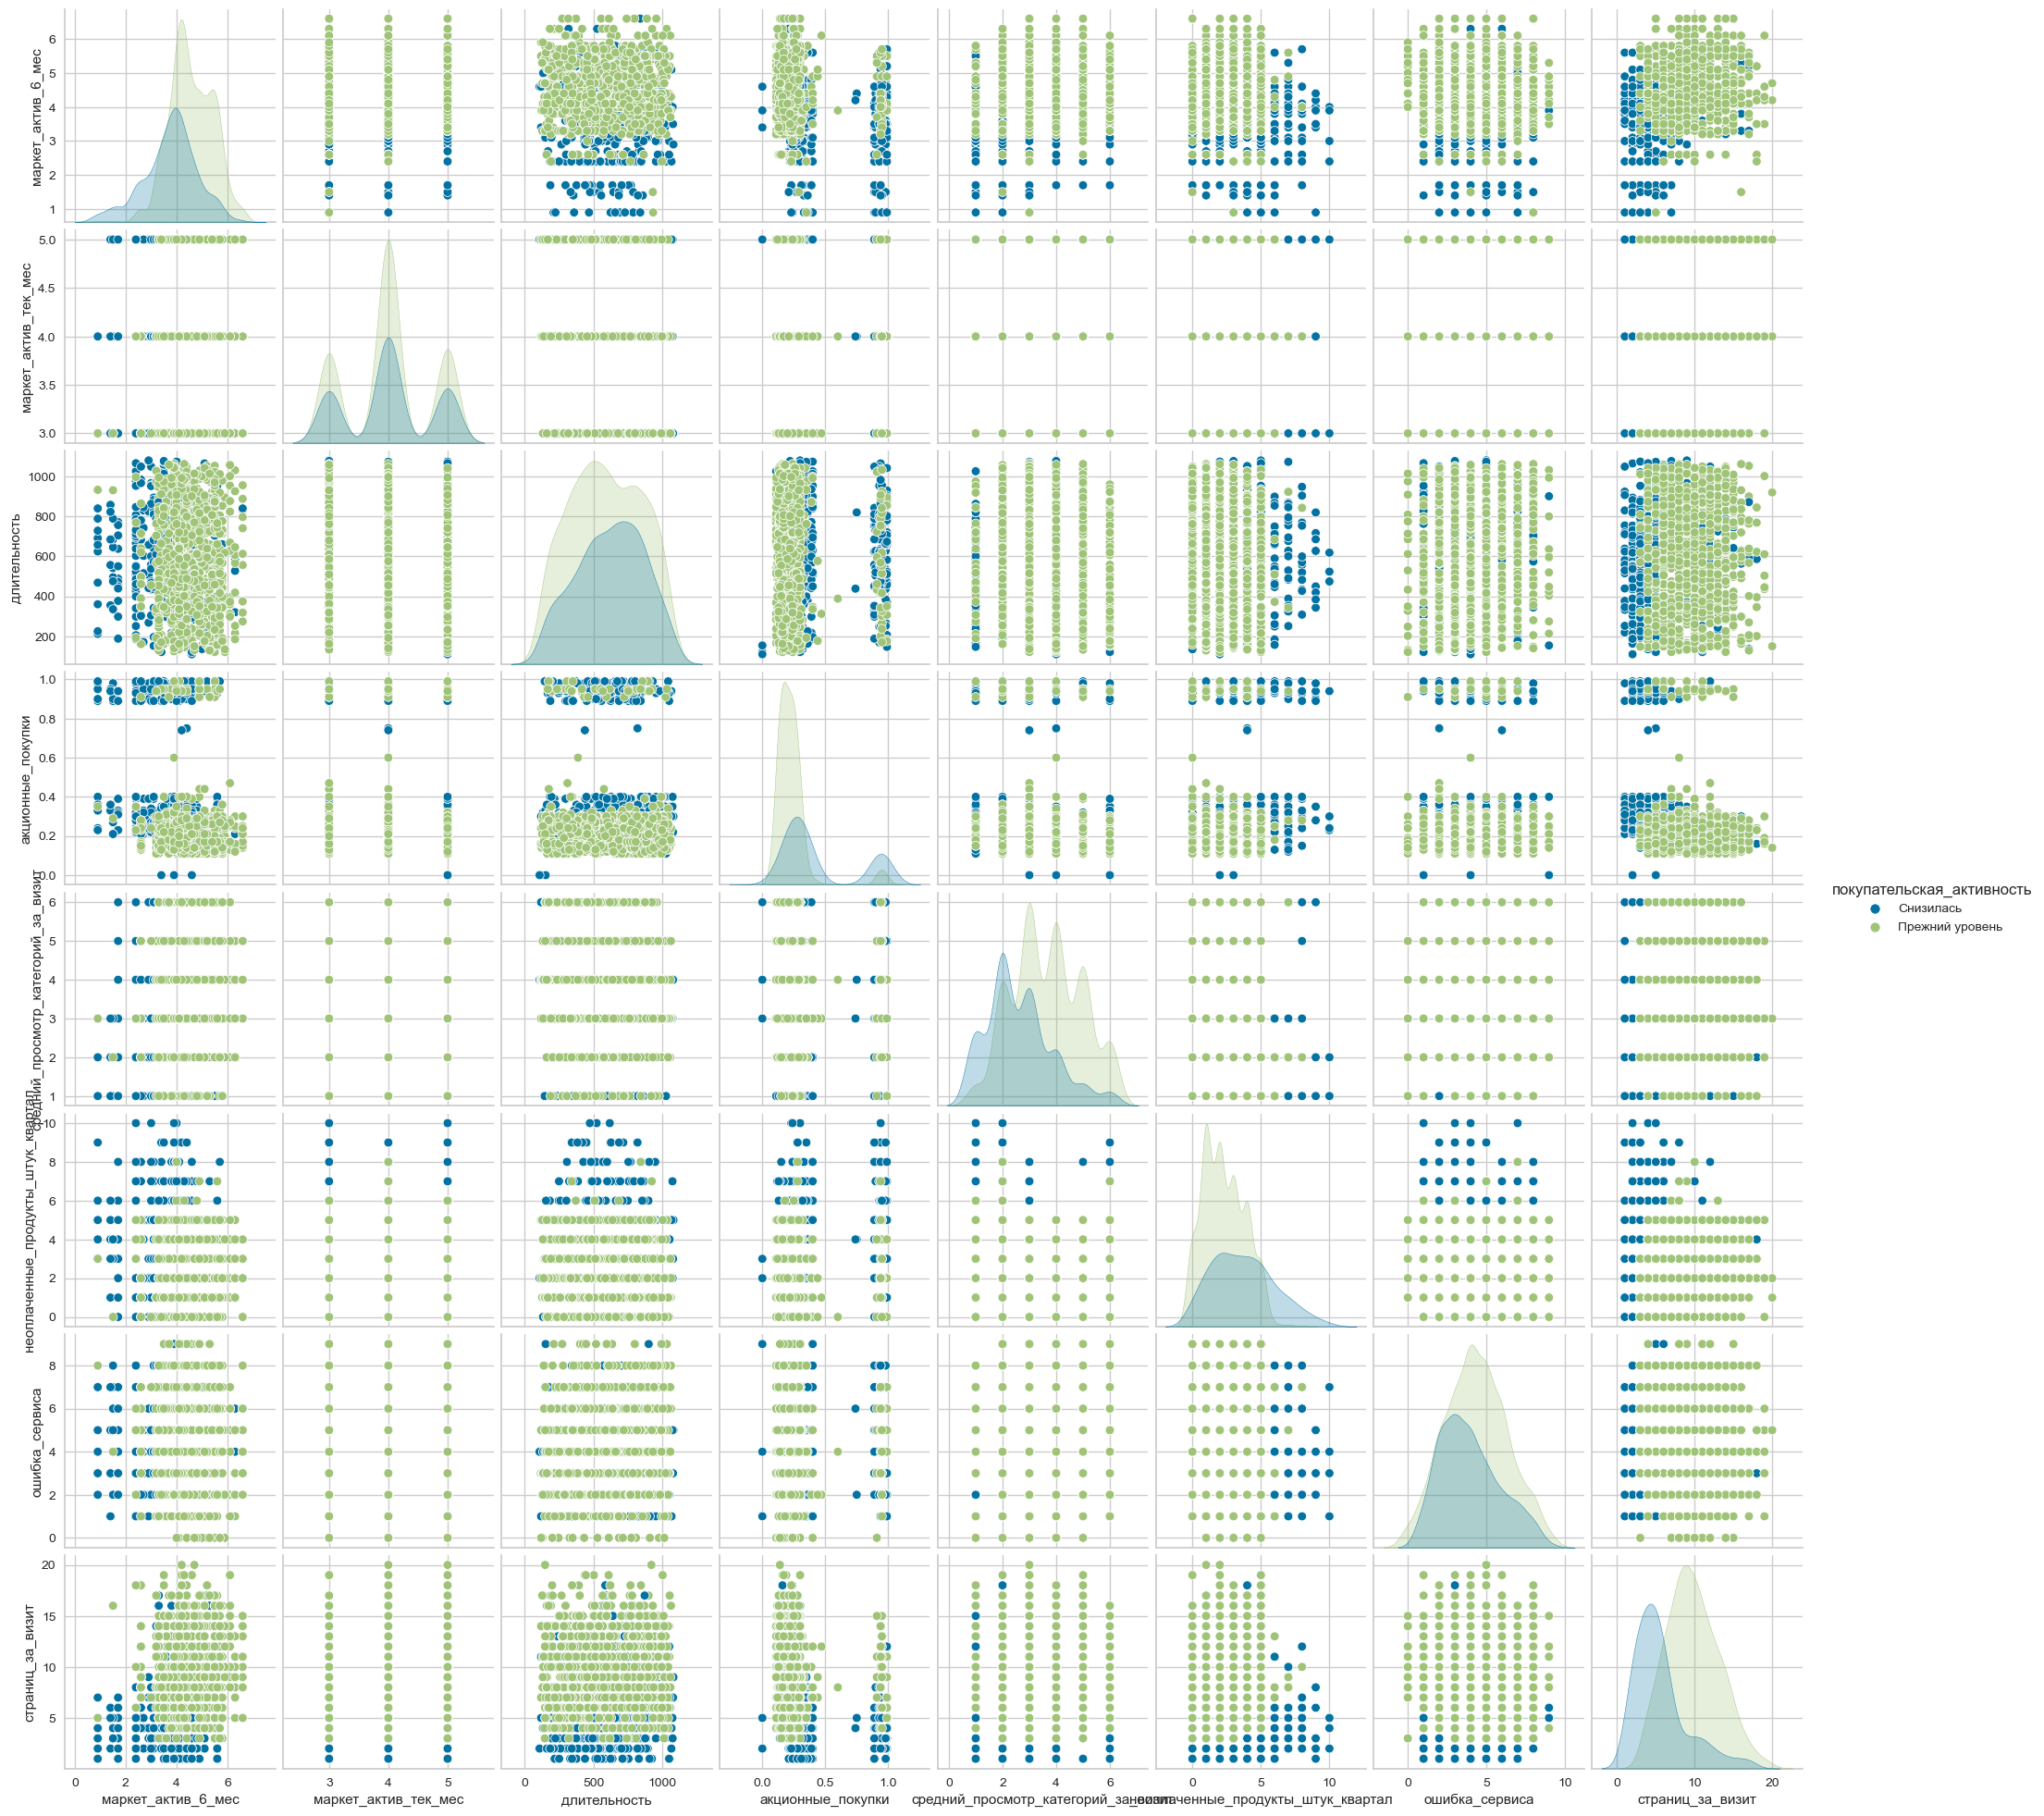

In [40]:
sns.pairplot(market[['маркет_актив_6_мес', 'маркет_актив_тек_мес', \
                     'длительность', 'акционные_покупки', \
                     'средний_просмотр_категорий_за_визит', \
                     'неоплаченные_продукты_штук_квартал', \
                     'ошибка_сервиса', 'страниц_за_визит', \
                     'покупательская_активность']], \
                     hue='покупательская_активность')
plt.show()

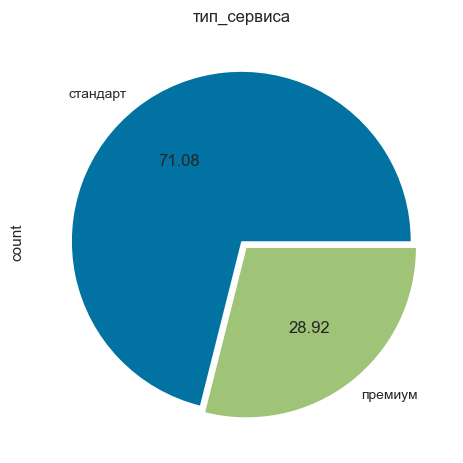

In [41]:
ax1 = market['тип_сервиса'].value_counts().plot(kind='pie',
        autopct = '%.2f', explode=[0, 0.05])
ax1.set_title('тип_сервиса', fontsize = 12)
plt.show()

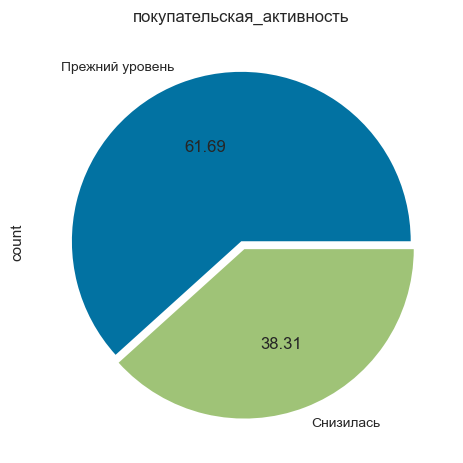

In [42]:
ax1 = market['покупательская_активность'].value_counts().plot(kind='pie', 
        autopct = '%.2f', explode=[0, 0.05])
ax1.set_title('покупательская_активность', fontsize = 12)
plt.show()

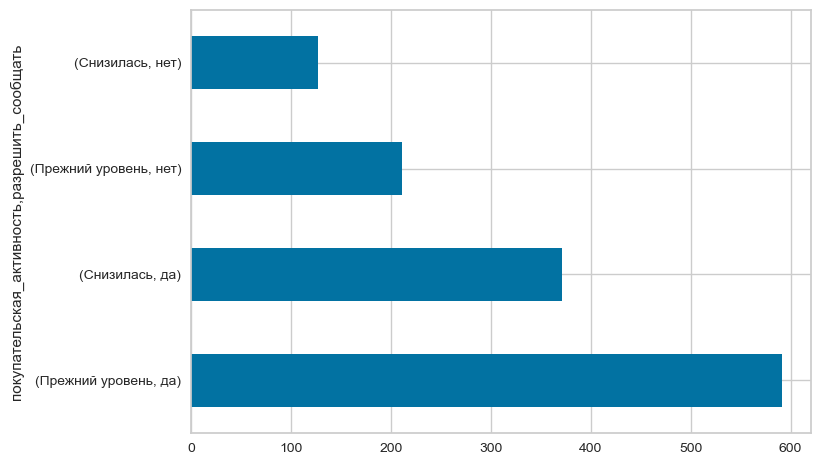

In [43]:
market[['покупательская_активность', 'разрешить_сообщать']].value_counts().plot.barh()
plt.show()

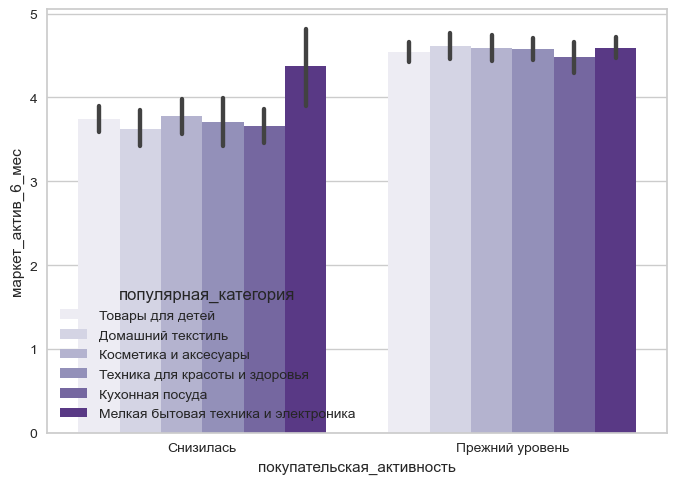

In [44]:
sns.barplot(x='покупательская_активность', y='маркет_актив_6_мес', hue='популярная_категория', data=market, palette='Purples')
plt.show()

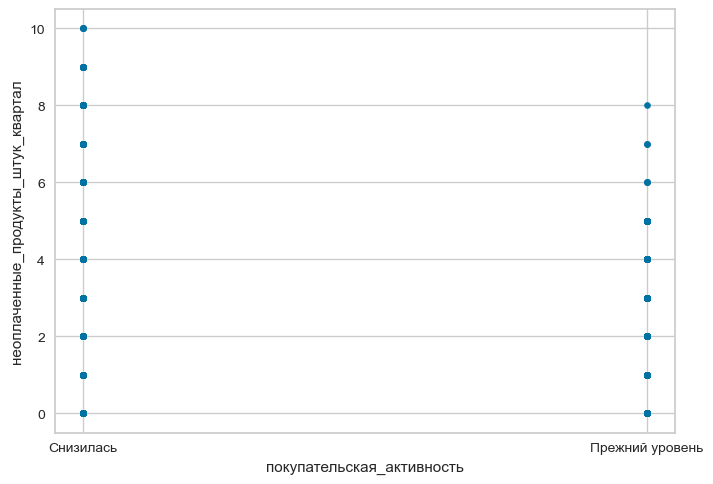

In [45]:
ax = market.plot(x='покупательская_активность', y='неоплаченные_продукты_штук_квартал', kind='scatter')

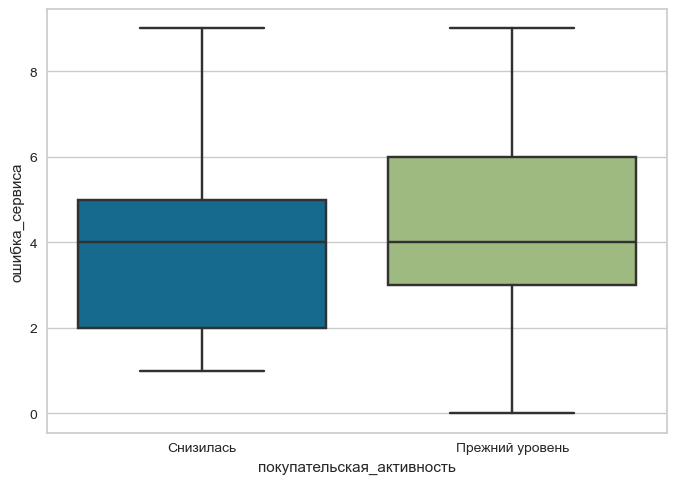

In [46]:
ax = sns.boxplot(data=market, x='покупательская_активность', y='ошибка_сервиса')

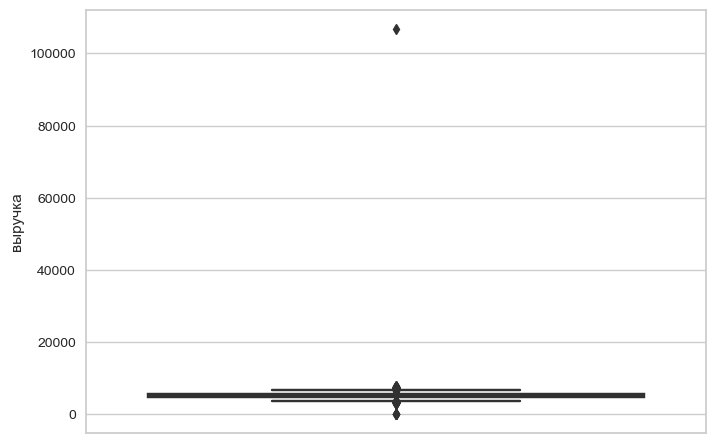

In [47]:
ax = sns.boxplot(y='выручка', data=market_money)

In [48]:
market_money = market_money.query('выручка < 20000')

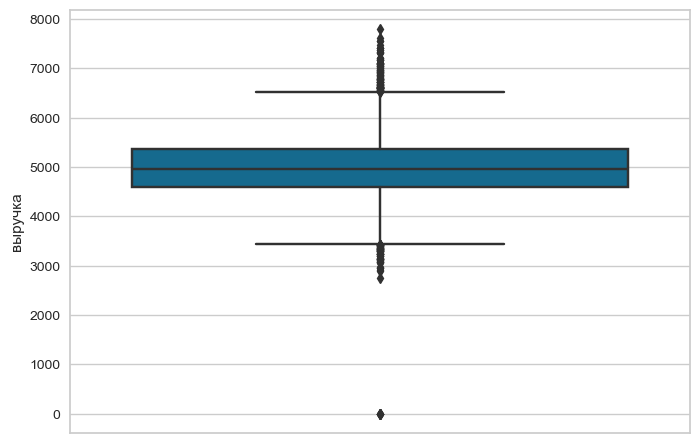

In [49]:
ax = sns.boxplot(y='выручка', data=market_money)

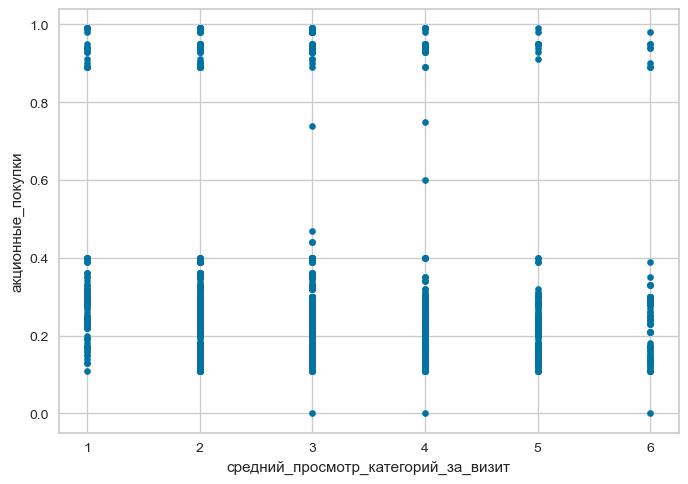

In [50]:
market.plot(x='средний_просмотр_категорий_за_визит',y='акционные_покупки',kind='scatter')
plt.show()

In [51]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [52]:
money.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [53]:
market_money_pivot = pd.pivot_table(market_money, index='id', columns='период', values='выручка')
market_money_pivot.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_pivot = market_money_pivot.reset_index()

In [54]:
market_money_pivot = market_money_pivot[(market_money_pivot['выручка_предыдущий_месяц'] != 0) & \
                                        (market_money_pivot['выручка_препредыдущий_месяц'] != 0)]
print(market_money_pivot.shape)

(1297, 4)


In [55]:
market_money_pivot.head(5)

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
5,215353,4738.5,5124.0,5388.5


In [56]:
market_money_pivot.isna().sum()

id                             0
выручка_предыдущий_месяц       0
выручка_препредыдущий_месяц    0
выручка_текущий_месяц          1
dtype: int64

In [57]:
# т.к. образуется пропуск заполним его медианным значением
market_money_pivot['выручка_текущий_месяц'] = market_money_pivot['выручка_текущий_месяц'] \
        .fillna(market_money['выручка'].median())

**вывод**
- больше всего покупателей класса "стандарт" - около 70%
- покупательская активность снизилась у 40% клиентов
- большинство клиентов давало согласие на получение дополнительной информации о товаре
- покупательская активность больше всего снизилась в категории "Мелкая бытовая техника и электроника"
- чем у клиентов со сниженной активностью больше неоплаченных товаров
- у клинтов со сниженной активностью ошибка сервиса встречалась немного чаще. У клиентов с нулевой ошибкой активность не снизилась

## Объединение таблиц

In [58]:
lst_id = market_money_pivot['id'].tolist()

In [59]:
market = market.query('id in @lst_id')

In [60]:
market_time_pivot = market_time.pivot_table(index='id', columns='период', values='минут')
market_time_pivot = market_time_pivot.query('id in @lst_id')
market_time_pivot.columns = ['время_предыдущий_месяц', 'время_текущий_месяц']
market_time_pivot = market_time_pivot.reset_index()

In [61]:
df = market.merge(market_time_pivot, on='id', how='right')
data = df.merge(market_money_pivot, on='id', how='right')
data.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12.0,10.0,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8.0,13.0,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11.0,13.0,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8.0,11.0,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10.0,10.0,4738.5,5124.0,5388.5


In [62]:
# код ревьюера
data['выручка_текущий_месяц'].max()

7799.4

## Корреляционный анализ

In [63]:
data[['маркет_актив_6_мес', 
      'маркет_актив_тек_мес',
      'длительность', 
      'акционные_покупки', 
      'средний_просмотр_категорий_за_визит', \
      'неоплаченные_продукты_штук_квартал', \
     'ошибка_сервиса', \
     'страниц_за_визит', \
     'время_предыдущий_месяц', \
     'время_текущий_месяц', \
     'выручка_предыдущий_месяц', \
     'выручка_препредыдущий_месяц', \
     'выручка_текущий_месяц']].corr(method='spearman')

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
маркет_актив_6_мес,1.000000,0.061697,-0.044614,-0.277968,0.185027,-0.134368,0.038656,0.319918,0.274003,0.226345,-0.005652,0.233325,0.002680
маркет_актив_тек_мес,0.061697,1.000000,-0.131979,0.033045,-0.025158,0.061754,0.087351,0.003144,0.013538,-0.063044,-0.027107,-0.039397,-0.011758
длительность,-0.044614,-0.131979,1.000000,0.029186,-0.043150,-0.108822,0.103528,-0.034591,-0.124000,0.083035,0.013739,-0.039284,0.014968
акционные_покупки,-0.277968,0.033045,0.029186,1.000000,-0.203380,0.197624,-0.051590,-0.370853,-0.332743,-0.274693,0.007035,-0.267790,0.021681
средний_просмотр_категорий_за_визит,0.185027,-0.025158,-0.043150,-0.203380,1.000000,-0.251448,0.010034,0.267536,0.148376,0.233358,-0.049596,0.149619,-0.070625
неоплаченные_продукты_штук_квартал,-0.134368,0.061754,-0.108822,0.197624,-0.251448,1.000000,-0.098544,-0.165297,-0.183426,-0.214803,0.032958,-0.249421,0.061280
ошибка_сервиса,0.038656,0.087351,0.103528,-0.051590,0.010034,-0.098544,1.000000,0.104508,0.196017,0.078089,0.035383,0.090105,0.040518
страниц_за_визит,0.319918,0.003144,-0.034591,-0.370853,0.267536,-0.165297,0.104508,1.000000,0.450913,0.298113,-0.067879,0.311428,-0.049886
время_предыдущий_месяц,0.274003,0.013538,-0.124000,-0.332743,0.148376,-0.183426,0.196017,0.450913,1.000000,0.360375,-0.084632,0.348403,-0.143179
время_текущий_месяц,0.226345,-0.063044,0.083035,-0.274693,0.233358,-0.214803,0.078089,0.298113,0.360375,1.000000,-0.082747,0.299989,-0.164872


Самая высокая связь наблюдается между значениями выручки в разные месяцы при этом порог в 0.9 она не переходит и   также нам важно изучить динамику продаж в разные месяцы, а остальные признаки не сильно коррелируют между собой, поэтому считаем, что мультиколинеарности нет.

## Использование пайплайнов

In [64]:
RANDOM_STATE = 42

X = data.set_index('id').drop(['покупательская_активность'], axis=1)
y = data['покупательская_активность']


X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE)

In [65]:
ohe_columns = [
    'разрешить_сообщать', 
    'тип_сервиса'
 
    
]
ord_columns = [
    'популярная_категория'
]
num_columns = ['маркет_актив_6_мес', \
               'маркет_актив_тек_мес', \
                'длительность', \
               'акционные_покупки', \
               'средний_просмотр_категорий_за_визит', \
                'неоплаченные_продукты_штук_квартал', \
                'ошибка_сервиса', \
                'страниц_за_визит', \
                'время_предыдущий_месяц', \
                'время_текущий_месяц', \
               'выручка_предыдущий_месяц', \
               'выручка_препредыдущий_месяц', \
               'выручка_текущий_месяц']

In [66]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [67]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    #['стандарт', 'премиум'], \
                    ['Товары для детей', 'Домашний текстиль', \
                     'Косметика и аксесуары', 'Кухонная посуда', \
                     'Техника для красоты и здоровья',
                    'Мелкая бытовая техника и электроника']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [68]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [69]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [70]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [86]:
# обучаем модель на тренировочной выборке
pipe_final.fit(X_train, y_train_encoded)


# выводим предсказанные значения тестовой выборки
y_test_pred = pipe_final.predict(X_test)

In [72]:
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(kernel = 'linear', random_state=RANDOM_STATE)],
        'models__degree': range(1, 15),
        #'models__kernel': ['poly', 'rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },

     # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
        )],
        'models__C': range(1, 5),
        'models__solver' : ['liblinear', 'saga'],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    }
]

In [73]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
# print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'тип_сервиса']),
                                                 ('ord',
                                          

/Users/vladimirkalinovskii/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vladimirkalinovskii/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vladimirkalinovskii/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vladimirkalinovskii/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [74]:
probabilities_one = randomized_search.predict_proba(X_test)[:,1]

print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.908454624990058


***

**7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.    
7.2 Сделайте выводы о значимости признаков:   
какие признаки мало значимы для модели;   
какие признаки сильнее всего влияют на целевой признак;   
как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.**

***

In [75]:
xtr = data_preprocessor.fit_transform(X_train)
xtst = data_preprocessor.transform(X_test)
X_train_processed = pd.DataFrame(xtr, columns=data_preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(xtst, columns=data_preprocessor.get_feature_names_out())
# y_train_encoded
# y_test_encoded

***

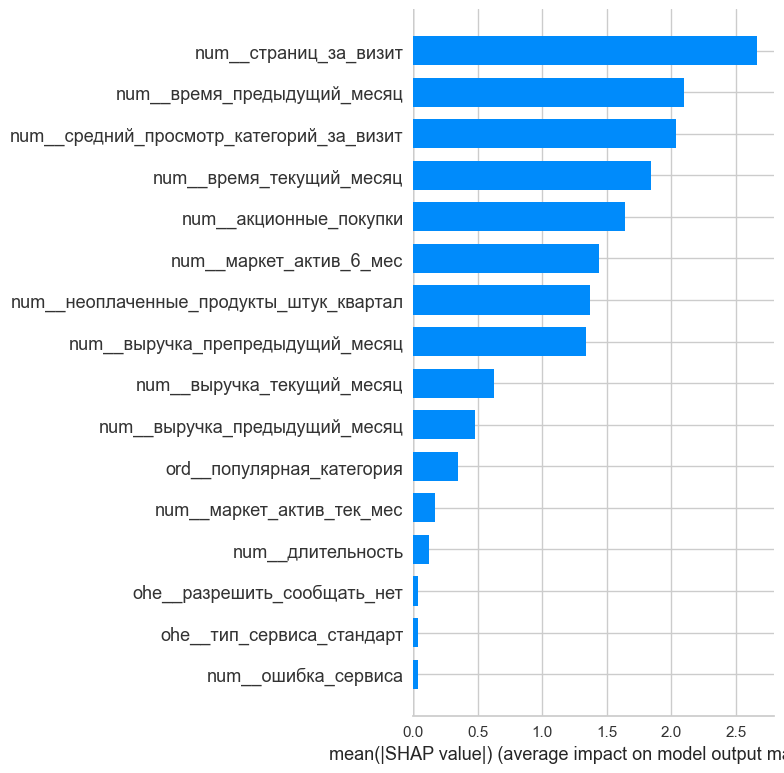

In [76]:
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_test_processed)

shap_values = explainer(X_test_processed)
shap.summary_plot(shap_values, X_test_processed, plot_type='bar', feature_names = feature_names)

## Сегментация покупателей

(array([108.,  43.,  31.,  20.,  13.,   9.,   7.,  16.,  20.,  58.]),
 array([0.00355943, 0.10293741, 0.2023154 , 0.30169339, 0.40107138,
        0.50044937, 0.59982736, 0.69920535, 0.79858334, 0.89796133,
        0.99733932]),
 <BarContainer object of 10 artists>)

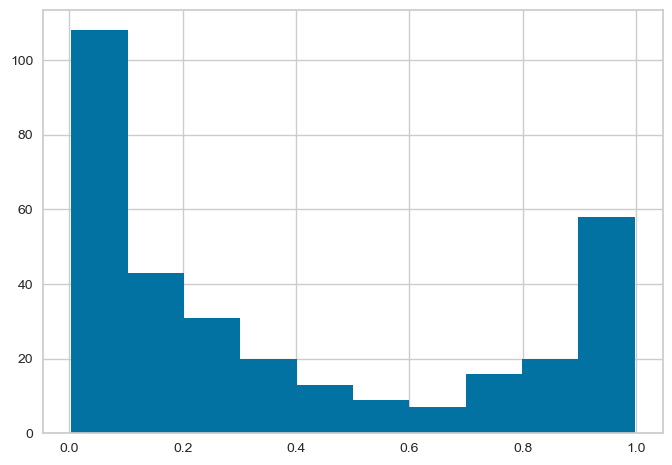

In [77]:
plt.hist(randomized_search.predict_proba(X_test)[:,1])

In [78]:
prob = pd.DataFrame(pd.concat([
    pd.Series(randomized_search.predict_proba(X_test)[:,1]),
    pd.Series(X_test.index)
], axis=1))
prob.columns = ['вероятность_снижения_активности', 'id']
prob_money = prob.merge(money, on='id')

In [79]:
cat = X_test['популярная_категория']
cat.columns = ['id', 'популярная_категория']

sales = X_test['акционные_покупки']
sales.columns = ['id', 'акционные_покупки']

types = X_test['тип_сервиса']
types.columns = ['id', 'тип_сервиса']

notif = X_test['разрешить_сообщать']
notif.columns = ['id', 'популярная_категория']

prob_money = prob_money.merge(cat, on='id')
prob_money = prob_money.merge(sales, on='id')
prob_money = prob_money.merge(types, on='id')
prob_money = prob_money.merge(notif, on='id')

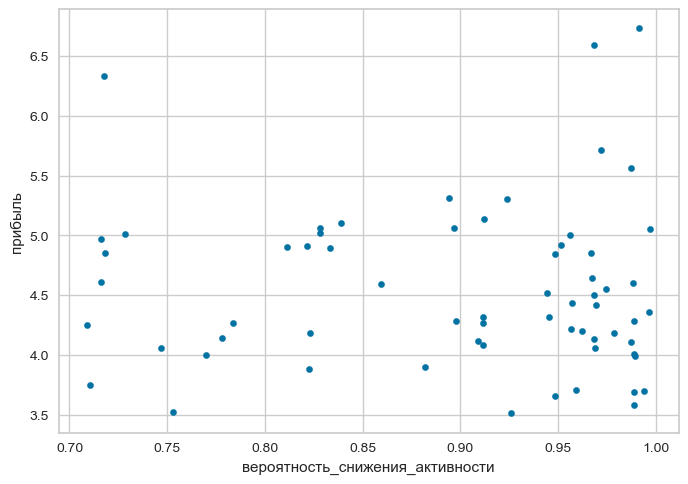

In [80]:
prob_money.query('вероятность_снижения_активности > 0.7 and прибыль > 3.5').plot(x="вероятность_снижения_активности", y="прибыль", kind='scatter')
plt.show()

- **покупатели с вероятностью снижения активности более 90% совершают больше покупок чем в интервале с вероятностью 50% - 90% и также они совершают более дорогие покупки поэтому рассмотрим этот сегмент более подробно.**

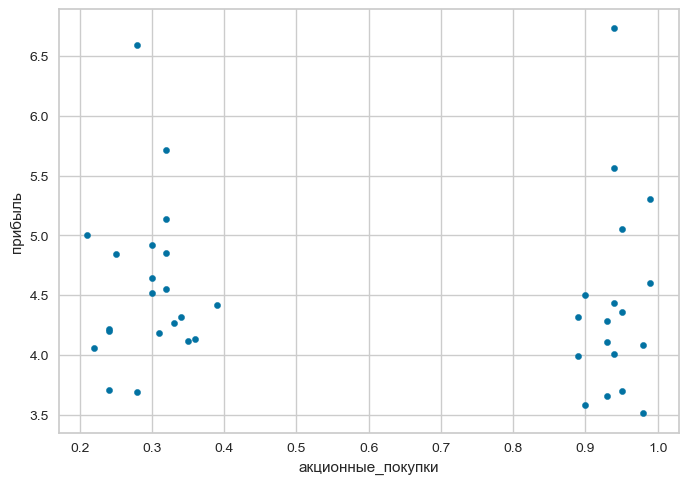

In [81]:
ax = prob_money.query('вероятность_снижения_активности > 0.9 and прибыль > 3.5'). \
                        plot(x="акционные_покупки", y="прибыль", kind='scatter')

- **данный сегмент покупателей делится на 2 категории: тех, кто покупает почти всё на скидках и тех кто умеренно использует скидки. Возьмём тех, кто почти всегда покупает акционные товары, вероятность снижения их активности может быть связано с завершением скидок (например зимния сезон скидок) и их началом ожидания следующего такого сезона**

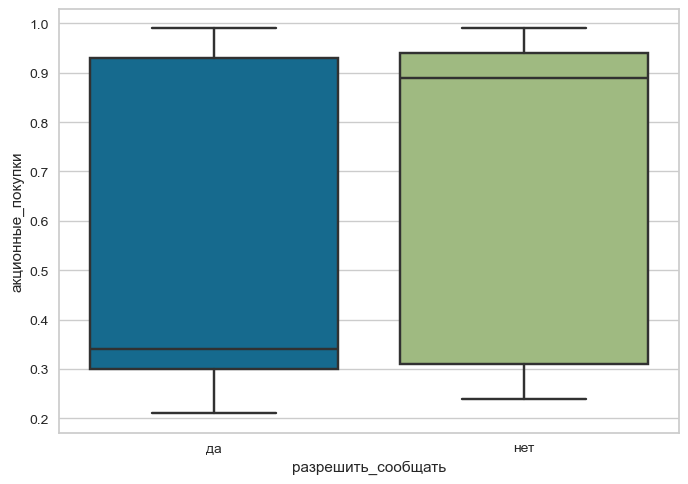

In [82]:
sns.boxplot(data=prob_money.query('вероятность_снижения_активности > 0.9 and прибыль > 3.5'), \
            x='разрешить_сообщать', y='акционные_покупки')
plt.show()

- **мы заинтересованы в покупателях, которые в основном совершают акционные покупки, поэтому т.к. медиана для категории "не сообщать" смещена гораздо выше противоположной категории, то возьмём "не сообщать"**

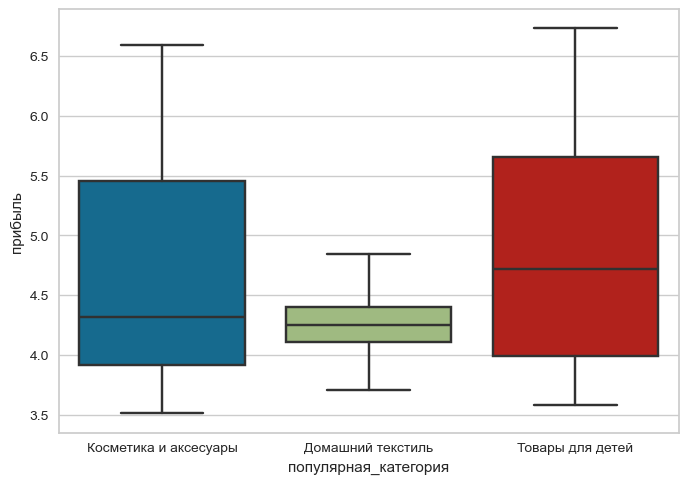

In [83]:
sns.boxplot(data=prob_money.query('вероятность_снижения_активности > 0.9 and прибыль > 3.5 \
                    and разрешить_сообщать == "нет"'), \
                    x='популярная_категория', y='прибыль')
plt.show()

- **наш сегмент в основном заинтересован в категориях "косметика и аксессуары" и "товары для детей", то есть совершаются сезонные покупки, которые требуют обновления.**

**Рекомендации**
- т.к. дети взрослеют можно для людей интересующихся этой категорией можно отслеживать товарами для какого возраста они интересуются и в то же время предлагать товары для более взрослых детей с акциями. Покутели будут видеть хорошее предложение, понимать, что дети растут и они в любом случае купят этот товар и будут заинтересованы.
- для категории "косметика и аксессуары" можно предлагать акционные товары для противополоного пола например: девушка ищет помаду, но также видит, что есть хорошее предложение на пену для бритья и будет заинтересована для покупки товара в подарок.  
  **это увеличит прибыль в выбранном сегменте и также увеличит активность** 

## Общий вывод

- заметили опечатки: "стандартт" -> "стандарт", "предыдцщий_месяц" -> "предыдущий_месяц"
- избавились от выброса в выручке
- расформировали выручку по месяцам
- больше всего покупателей класса "стандарт" - около 70%
- покупательская активность снизилась у 40% клиентов
- большинство клиентов давало согласие на получение дополнительной информации о товаре
- покупательская активность больше всего снизилась в категории "Мелкая бытовая техника и электроника"
- чем у клиентов со сниженной активностью больше неоплаченных товаров
- у клинтов со сниженной активностью ошибка сервиса встречалась немного чаще. У клиентов с нулевой ошибкой активность не снизилась
- покупатели делятся на два типа: 1) те, кто не особо обращают внимание на скидки (до 40% покупок) и 2) тех кто почти все покупки совершает со скидками.
- люди с типом сервиса "стандарт" покапают немного больше.
  
  
- для поиска лучшей модели создали пайплайн, который кодирует категориальные признаки 'разрешить_сообщать' и 
     'тип_сервиса' через OneHotEncoder, а признак 'популярная_категория' через OrdinalEncoder т.к. там много переменных и иначе было бы слишком много новых столбцов после кодирования. Далее через RandomizedSearchCV перебирали гиперпараметры для моделей и перебирали кодировщиков для численных признаков. Также кодировали целевой признак через LabelEncoder.
- Лучшая модель: LogisticRegression(C=2, random_state=42, solver='saga')




**Рекомендации**
- т.к. дети взрослеют можно для людей интересующихся этой категорией можно отслеживать товарами для какого возраста они интересуются и в то же время предлагать товары для более взрослых детей с акциями. Покутели будут видеть хорошее предложение, понимать, что дети растут и они в любом случае купят этот товар и будут заинтересованы.
- для категории "косметика и аксессуары" можно предлагать акционные товары для противополоного пола например: девушка ищет помаду, но также видит, что есть хорошее предложение на пену для бритья и будет заинтересована для покупки товара в подарок.  
  **это увеличит прибыль в выбранном сегменте и также увеличит активность** 